In [10]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import sys
import os
sys.path.append(os.path.abspath("."))  

In [11]:
import pickle
import cv2
from trackers.predict_utils import getPredictions

VIDEO_PATH = "data/cropped_videos/video1_cropped.mp4"
OUTPUT_PKL = "outputs/ball_positions.pkl"
IMGS_PER_BATCH = 5

cap = cv2.VideoCapture(VIDEO_PATH)

frames = []
original_frames = []
batch_index = 0
all_ball_positions = []

while True:
    ret, frame = cap.read()
    if not ret:
        break

    original_frames.append(frame.copy())
    frames.append(frame)

    if len(frames) == IMGS_PER_BATCH:
        # Get ball positions using your prediction function
        ball_positions = getPredictions(original_frames, isBGRFormat=True)
        all_ball_positions.extend(ball_positions)

        frames = []
        original_frames = []
        batch_index += 1
        print(f"Processed batch {batch_index}", end="\r")

cap.release()

# Save all ball positions to a pickle file for later use
with open(OUTPUT_PKL, 'wb') as f:
    pickle.dump(all_ball_positions, f)

print(f"\nSaved ball positions to {OUTPUT_PKL}")




Processed batch 75
Saved ball positions to outputs/ball_positions.pkl


In [12]:
import pickle

# Change the path to the pickle file generated in your project
pkl_path = "outputs/ball_positions1.pkl"

with open(pkl_path, 'rb') as f:
    ball_positions = pickle.load(f)

print(f"Loaded {len(ball_positions)} ball position entries")

# The elements in ball_positions should be lists or tuples like (x, y)
print(ball_positions[:5])  # Show first 5 positions to verify


Loaded 270 ball position entries
[(0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]


In [13]:
# Cleans invalid ball positions by replacing them with NaN, then interpolates missing values 
# to smooth the ball's trajectory and fills remaining gaps.


import pandas as pd
import numpy as np

# ball_positions viene de getPredictions, por ejemplo:
# ball_positions = [(x1, y1), (x2, y2), ..., (xn, yn)]

# Primero, si hay valores vacíos o inválidos, cámbialos por np.nan para poder interpolar
cleaned_positions = []
for pos in ball_positions:
    x, y = pos
    if x <= 0 or y <= 0:
        cleaned_positions.append((np.nan, np.nan))
    else:
        cleaned_positions.append((x, y))

# Crear DataFrame con columnas 'x' e 'y'
df_ball_positions = pd.DataFrame(cleaned_positions, columns=['x', 'y'])

# Interpolar valores faltantes (NaN) para suavizar la trayectoria
df_ball_positions = df_ball_positions.interpolate()

# Rellenar valores NaN restantes hacia atrás (backfill)
df_ball_positions = df_ball_positions.bfill()

# Mostrar resultado
print(df_ball_positions.head(10))


            x      y
0  772.000000  705.0
1  772.000000  705.0
2  772.000000  705.0
3  772.000000  705.0
4  772.000000  705.0
5  772.000000  705.0
6  777.000000  672.0
7  787.000000  632.0
8  783.666667  582.0
9  780.333333  532.0


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

#processes the vertical positions of a tennis ball over time to detect the frames where significant hits  occur by finding peaks and filtering out noise.


# Extract Y positions, replace invalid values with -1
y_positions = [pos[1] if pos[1] > 0 else -1 for pos in ball_positions]
df_ball_positions = pd.DataFrame({'y1': y_positions})

# Smooth the signal using rolling average
df_ball_positions['mid_y_rolling_mean'] = df_ball_positions['y1'].rolling(window=5, min_periods=1).mean()
signal = df_ball_positions['mid_y_rolling_mean'].values

# Parameters to detect meaningful peaks (hits)
MIN_DISTANCE = 25       # Minimum distance between peaks (frames)
MIN_PROMINENCE = 130    # Minimum prominence to consider a peak significant

# Detect local maxima and minima in the signal
peaks_max, _ = find_peaks(signal, distance=MIN_DISTANCE, prominence=MIN_PROMINENCE)
peaks_min, _ = find_peaks(-signal, distance=MIN_DISTANCE, prominence=MIN_PROMINENCE)

# Combine and sort all detected peaks
all_peaks = sorted(list(peaks_max) + list(peaks_min))

# Group close peaks and keep the most prominent one in each group
def group_close_peaks(peaks, signal, max_frame_gap=20):
    if not peaks:
        return []
    grouped = []
    current_group = [peaks[0]]

    for p in peaks[1:]:
        if p - current_group[-1] <= max_frame_gap:
            current_group.append(p)
        else:
            best_peak = max(current_group, key=lambda x: abs(signal[x]))
            grouped.append(best_peak)
            current_group = [p]

    best_peak = max(current_group, key=lambda x: abs(signal[x]))
    grouped.append(best_peak)
    return grouped

final_hits = group_close_peaks(all_peaks, signal, max_frame_gap=20)

# Filter out small vertical jumps to ignore minor fluctuations
def filter_small_vertical_jumps(peaks, signal, min_vertical_jump=100):
    if not peaks:
        return []

    filtered = [peaks[0]]  # Always keep the first peak

    for i in range(1, len(peaks)):
        prev_peak = filtered[-1]
        curr_peak = peaks[i]

        vertical_jump = abs(signal[curr_peak] - signal[prev_peak])
        if vertical_jump >= min_vertical_jump:
            filtered.append(curr_peak)

    return filtered

final_hits_filtered = filter_small_vertical_jumps(final_hits, signal, min_vertical_jump=120)

# Plot
plt.figure(figsize=(12, 6))
plt.plot(signal, label='Smoothed Ball Y Position')
plt.scatter(final_hits_filtered, signal[final_hits_filtered], color='red', label='Detected Hits (filtered)')
plt.xlabel('Frame')
plt.ylabel('Ball Y Position')
plt.title(' Hit Detection')
plt.legend()
plt.show()

print("Detected hits at frames:", final_hits_filtered)


NameError: name 'ball_positions' is not defined

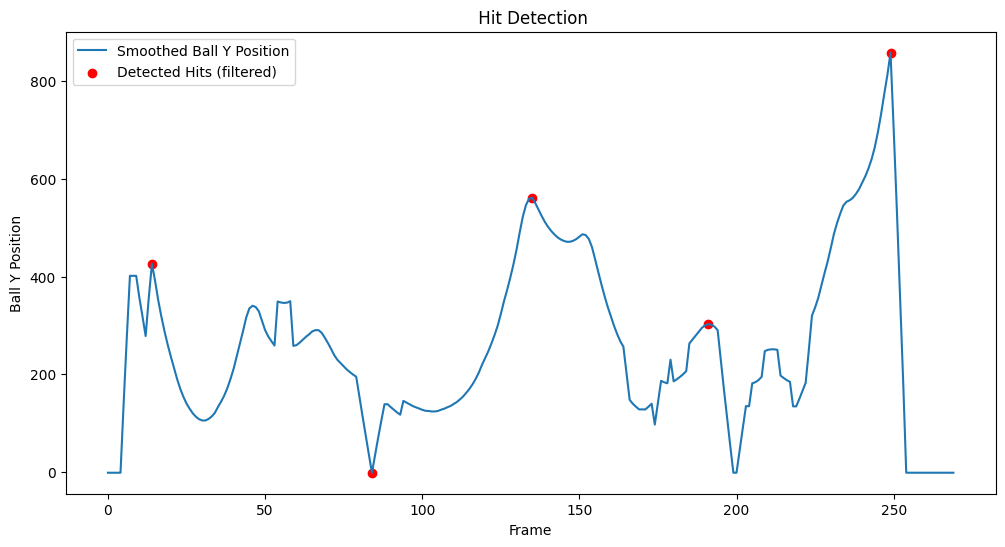

Detected hits at frames: [14, 84, 135, 191, 249]


In [21]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

#processes the vertical positions of a tennis ball over time to detect the frames where significant hits  occur by finding peaks and filtering out noise.


# Extract Y positions, replace invalid values with -1
y_positions = [pos[1] if pos[1] > 0 else -1 for pos in ball_positions]
df_ball_positions = pd.DataFrame({'y1': y_positions})

# Smooth the signal using rolling average
df_ball_positions['mid_y_rolling_mean'] = df_ball_positions['y1'].rolling(window=5, min_periods=1).mean()
signal = df_ball_positions['mid_y_rolling_mean'].values

# Parameters to detect meaningful peaks (hits)
MIN_DISTANCE = 25       # Minimum distance between peaks (frames)
MIN_PROMINENCE = 130    # Minimum prominence to consider a peak significant

# Detect local maxima and minima in the signal
peaks_max, _ = find_peaks(signal, distance=MIN_DISTANCE, prominence=MIN_PROMINENCE)
peaks_min, _ = find_peaks(-signal, distance=MIN_DISTANCE, prominence=MIN_PROMINENCE)

# Combine and sort all detected peaks
all_peaks = sorted(list(peaks_max) + list(peaks_min))

# Group close peaks and keep the most prominent one in each group
def group_close_peaks(peaks, signal, max_frame_gap=20):
    if not peaks:
        return []
    grouped = []
    current_group = [peaks[0]]

    for p in peaks[1:]:
        if p - current_group[-1] <= max_frame_gap:
            current_group.append(p)
        else:
            best_peak = max(current_group, key=lambda x: abs(signal[x]))
            grouped.append(best_peak)
            current_group = [p]

    best_peak = max(current_group, key=lambda x: abs(signal[x]))
    grouped.append(best_peak)
    return grouped

final_hits = group_close_peaks(all_peaks, signal, max_frame_gap=20)

# Filter out small vertical jumps to ignore minor fluctuations
def filter_small_vertical_jumps(peaks, signal, min_vertical_jump=100):
    if not peaks:
        return []

    filtered = [peaks[0]]  # Always keep the first peak

    for i in range(1, len(peaks)):
        prev_peak = filtered[-1]
        curr_peak = peaks[i]

        vertical_jump = abs(signal[curr_peak] - signal[prev_peak])
        if vertical_jump >= min_vertical_jump:
            filtered.append(curr_peak)

    return filtered

final_hits_filtered = filter_small_vertical_jumps(final_hits, signal, min_vertical_jump=120)

# Plot
plt.figure(figsize=(12, 6))
plt.plot(signal, label='Smoothed Ball Y Position')
plt.scatter(final_hits_filtered, signal[final_hits_filtered], color='red', label='Detected Hits (filtered)')
plt.xlabel('Frame')
plt.ylabel('Ball Y Position')
plt.title(' Hit Detection')
plt.legend()
plt.show()

print("Detected hits at frames:", final_hits_filtered)